# **PROGETTO DSL**
### Chiodo Martina - Bello Renato

A partire da dei dati vocali, si vuole creare una regressione per estrarre l'età dell'oratore.

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
# Loading the dataset using Pandas dataframe
data_dev = pd.read_csv('datasets/development.csv')
data_dev = data_dev.drop(columns=['Id'])
data_dev = data_dev.drop(columns = ['path'])

labels = list(data_dev.columns.values)
labels.remove('gender')
labels.remove('ethnicity')


# Displaying the first 5 rows of the dataset
print(data_dev.head())

   sampling_rate   age  gender   ethnicity  mean_pitch  max_pitch  min_pitch  \
0          22050  24.0  female      arabic   1821.6906  3999.7170  145.43066   
1          22050  22.5  female   hungarian   1297.8187  3998.8590  145.37268   
2          22050  22.0  female  portuguese   1332.8524  3998.8025  145.42395   
3          22050  22.0  female     english   1430.3499  3998.4510  147.98083   
4          22050  22.0    male       dutch   1688.7234  3998.6113  145.44772   

     jitter   shimmer    energy  zcr_mean  spectral_centroid_mean  \
0  0.013795  0.082725  0.002254  0.210093             3112.257251   
1  0.025349  0.096242  0.007819  0.078849             1688.016389   
2  0.019067  0.119456  0.002974  0.105365             2576.901706   
3  0.017004  0.102389  0.022371  0.173701             3269.751413   
4  0.028027  0.124831  0.005369  0.107279             1930.897375   

            tempo         hnr  num_words  num_characters  num_pauses  \
0  [151.99908088] -123.999726   

In [3]:
# Do we have some missing values?
null_values = data_dev.isnull().sum()
print("Count total NaN at each column in a DataFrame : \n\n", 
      null_values) 


Count total NaN at each column in a DataFrame : 

 sampling_rate             0
age                       0
gender                    0
ethnicity                 0
mean_pitch                0
max_pitch                 0
min_pitch                 0
jitter                    0
shimmer                   0
energy                    0
zcr_mean                  0
spectral_centroid_mean    0
tempo                     0
hnr                       0
num_words                 0
num_characters            0
num_pauses                0
silence_duration          0
dtype: int64


In [4]:
# First, let's convert tempo in a float data type
data_dev['tempo'] = data_dev['tempo'].str.replace('[','')
data_dev['tempo'] = data_dev['tempo'].str.replace(']','').astype(float)
data_dev

,sampling_rate,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,22050,24.0,female,arabic,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,281,39,23.846893
1,22050,22.5,female,hungarian,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,281,21,19.388662
2,22050,22.0,female,portuguese,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,281,1,21.640998
3,22050,22.0,female,english,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,281,9,19.644127
4,22050,22.0,male,dutch,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,281,11,18.041905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,22050,24.0,male,english,1641.14930,3999.1616,145.39359,0.023647,0.115361,0.001879,0.111799,2188.853478,184.570312,-100.921055,69,281,11,17.461406
2929,22050,15.0,female,igbo,1089.60050,3984.6550,145.58409,0.015317,0.126740,0.000339,0.070508,2712.362323,83.354335,6.757283,0,0,1,1.509206
2930,22050,17.0,female,igbo,994.46484,3989.1785,148.97475,0.009677,0.103535,0.001464,0.058442,2248.698477,89.102909,-53.913449,1,9,1,1.645034
2931,22050,18.0,male,arabic,1600.00820,3999.7559,145.36101,0.019571,0.100946,0.004451,0.115139,1834.596924,143.554688,-96.143090,69,281,19,16.346848


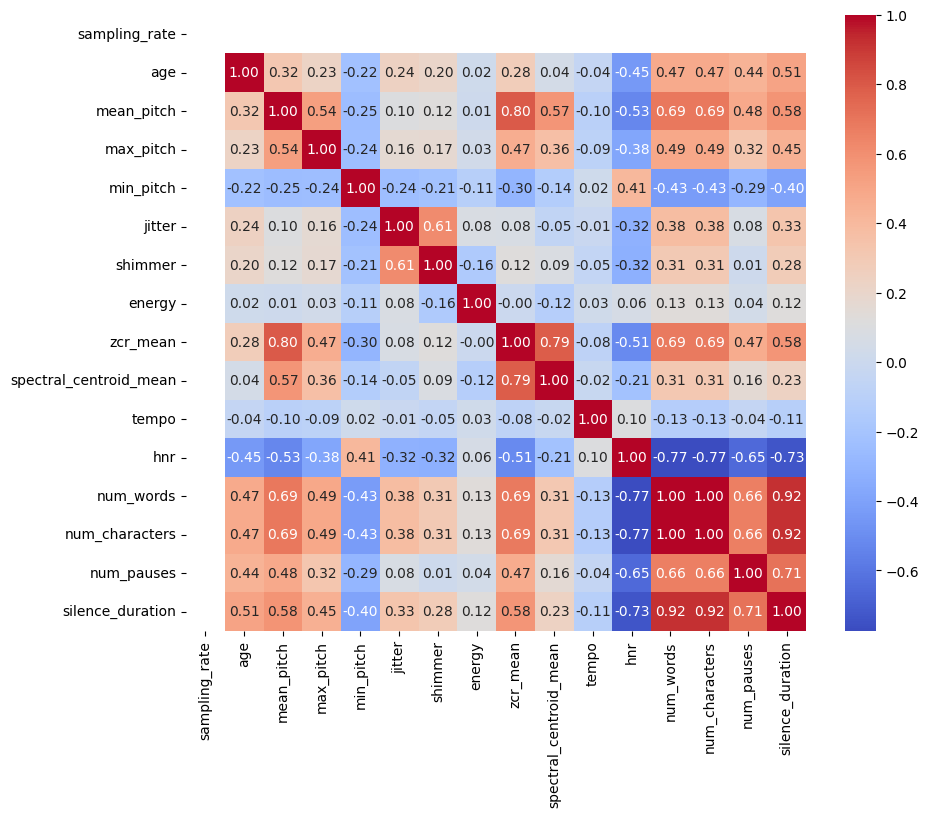

In [5]:
# Let's explore the correlation between features
correlation_matrix = data_dev[labels].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [6]:
# One-hot encoding for attribute gender and ethnicity
from collections import Counter
counts = dict(Counter(data_dev.ethnicity))
print('Numero di etnie', len(counts))

from sklearn.preprocessing import OneHotEncoder

# Crea il OneHotEncoder per "ethnicity"
all_categories_etn = sorted(set(data_dev['ethnicity']))
encoder_etn = OneHotEncoder(categories=[all_categories_etn], handle_unknown='ignore')
etn_encoded = encoder_etn.fit_transform(data_dev[['ethnicity']]).toarray()
etn_encoded_df = pd.DataFrame(etn_encoded, columns=['ethnicity_' + cat for cat in all_categories_etn])

# Crea il OneHotEncoder per "gender"
all_categories_gender = sorted(set(data_dev['gender']))
encoder_gender = OneHotEncoder(categories=[all_categories_gender], handle_unknown='ignore')
gender_encoded = encoder_gender.fit_transform(data_dev[['gender']]).toarray()
gender_encoded_df = pd.DataFrame(gender_encoded, columns=['gender_' + cat for cat in all_categories_gender])

# Riuniamo il dataset
data_dev = pd.concat([data_dev.reset_index(drop=True).drop(columns=['ethnicity']), etn_encoded_df], axis=1)
data_dev = pd.concat([data_dev.reset_index(drop=True).drop(columns=['gender']), gender_encoded_df], axis=1)

data_dev

Numero di etnie 165


,sampling_rate,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,...,ethnicity_sa'a,ethnicity_sardinian,ethnicity_sarua,ethnicity_satawalese,ethnicity_tiv,ethnicity_ukwani,ethnicity_urhobo,ethnicity_yoruba,gender_female,gender_male
0,22050,24.0,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,22050,22.5,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,22050,22.0,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,22050,22.0,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,22050,22.0,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,22050,24.0,1641.14930,3999.1616,145.39359,0.023647,0.115361,0.001879,0.111799,2188.853478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2929,22050,15.0,1089.60050,3984.6550,145.58409,0.015317,0.126740,0.000339,0.070508,2712.362323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2930,22050,17.0,994.46484,3989.1785,148.97475,0.009677,0.103535,0.001464,0.058442,2248.698477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2931,22050,18.0,1600.00820,3999.7559,145.36101,0.019571,0.100946,0.004451,0.115139,1834.596924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
etn_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2933, 165))

We have no missing values.

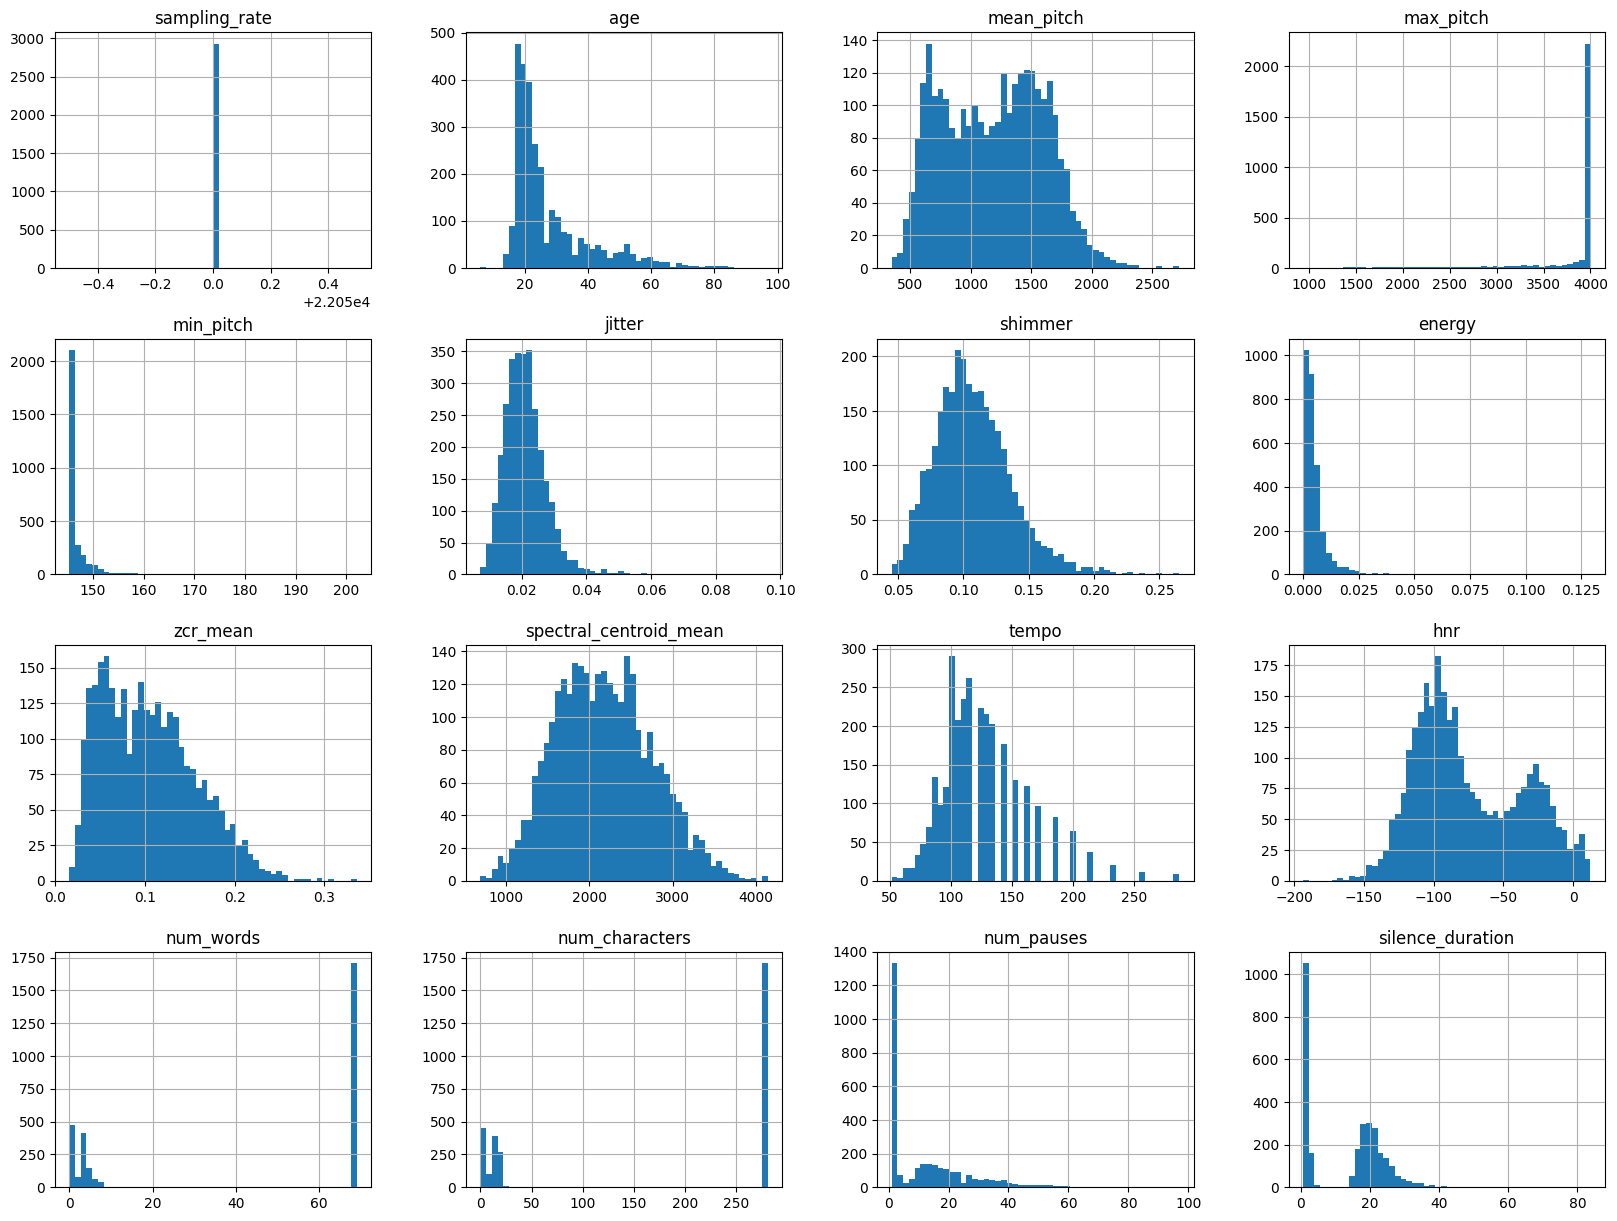

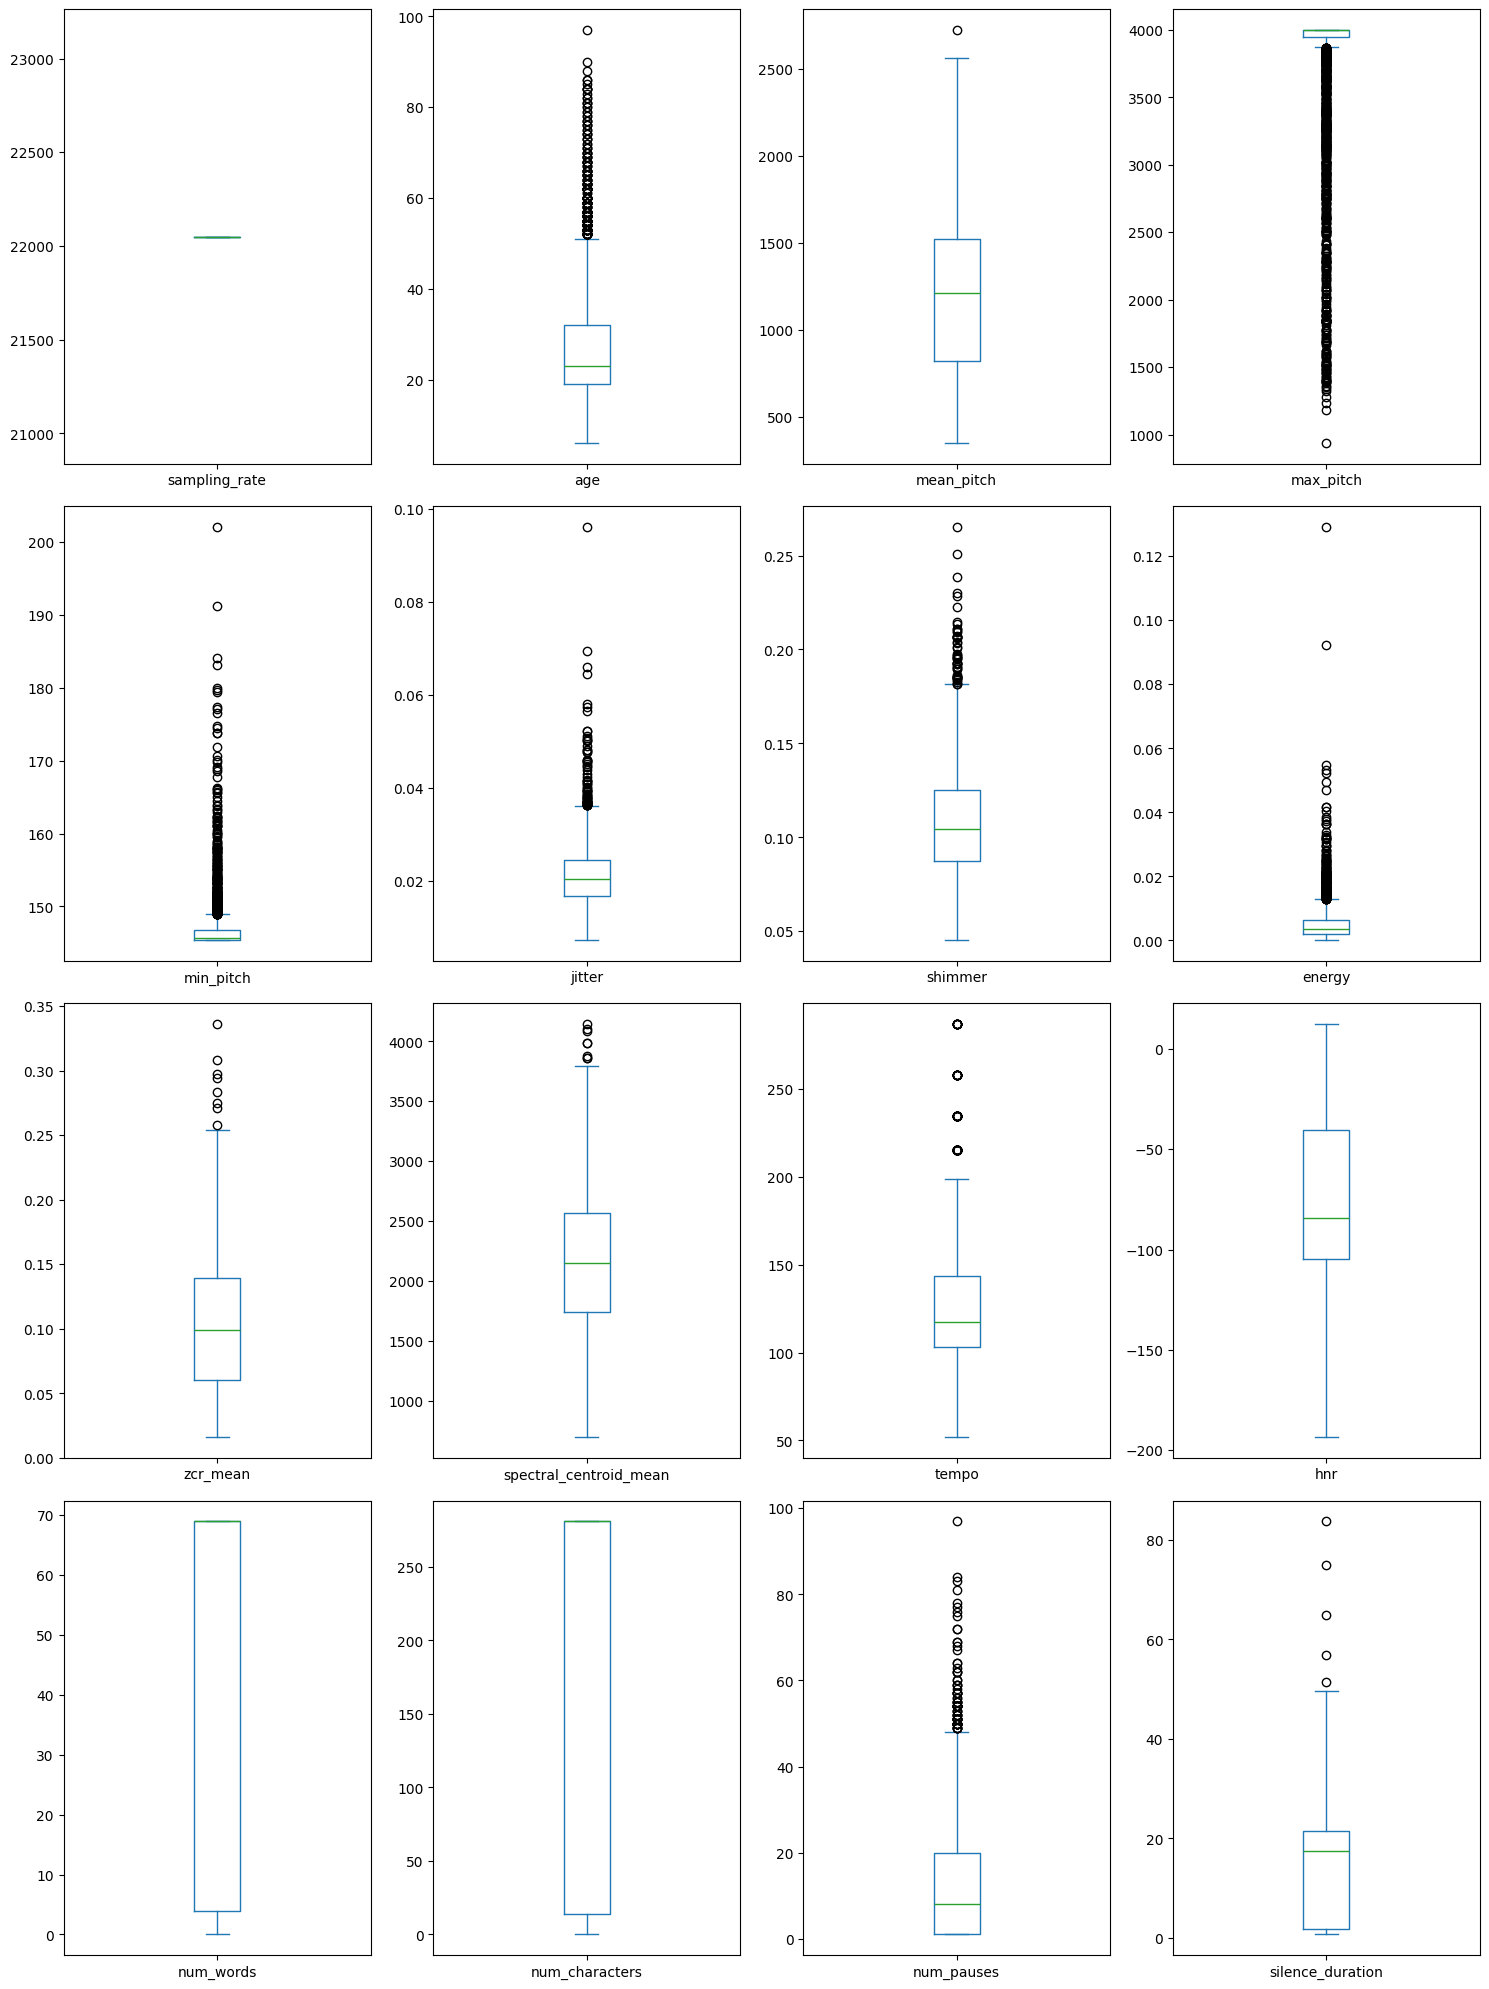

In [8]:
# Some plots to understand the data
data_dev[labels].hist(bins=50, figsize=(20, 15))
plt.show()

data_dev[labels].plot(kind='box', subplots=True, layout=(4, 4), figsize=(15, 20), sharex=False, sharey=False)
plt.tight_layout()
plt.show()


In [9]:
# Dividing the dataset into development and validation
X_train_valid, X_test, y_train_valid, y_test = train_test_split(data_dev.drop(columns=['age']), data_dev['age'], test_size=0.2, random_state=42)
X_train_valid.shape, X_test.shape, y_train_valid.shape, y_test.shape

standard_scaler = StandardScaler()
standard_scaler.fit_transform(X_train_valid)
standard_scaler.transform(X_test)

array([[ 0.        ,  0.33429385,  0.32911017, ..., -0.06205716,
         1.00684354, -1.00684354],
       [ 0.        , -0.83227257,  0.39947195, ..., -0.06205716,
         1.00684354, -1.00684354],
       [ 0.        , -1.61344236, -1.67857834, ..., -0.06205716,
        -0.99320298,  0.99320298],
       ...,
       [ 0.        ,  0.6523893 ,  0.38345488, ..., -0.06205716,
         1.00684354, -1.00684354],
       [ 0.        ,  0.1315472 ,  0.40187583, ..., -0.06205716,
        -0.99320298,  0.99320298],
       [ 0.        ,  1.38973105,  0.40774368, ..., -0.06205716,
        -0.99320298,  0.99320298]], shape=(587, 182))

## LEARNING THE REGRESSION MODEL

In [28]:
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


# Initialize the model
model = LinearRegression(   
    fit_intercept=True,  # calculate the y-intercept
)

best_i = 0
best_score = 1000

for i in range(1, X_train_valid.shape[1] + 1):
    rfe = RFE(model, n_features_to_select=i)  # select the 5 most important features
    rfe.fit(X_train_valid, y_train_valid)
    #print(rfe.support_)  # the mask of the selected features

    X_train_selected_linear = rfe.transform(X_train_valid)
    X_test_selected_linear = rfe.transform(X_test)

    # Fit the model
    model.fit(X_train_selected_linear, y_train_valid)
    score = root_mean_squared_error(y_test, model.predict(X_test_selected_linear))

    if score < best_score:
        best_score = score
        best_i = i
        print('Best score:', best_score, 'Best i:', best_i)

print('Best score:', best_score, 'Best i:', best_i)

Best score: 12.316945167011575 Best i: 1
Best score: 12.315297814119278 Best i: 2
Best score: 12.269170238371554 Best i: 4
Best score: 12.268736732481921 Best i: 8
Best score: 12.268427762796971 Best i: 12
Best score: 12.267630691366294 Best i: 13
Best score: 12.26730870127218 Best i: 14
Best score: 12.256992252257431 Best i: 31
Best score: 12.256884087447872 Best i: 36
Best score: 12.23152380820507 Best i: 37
Best score: 11.189649837467682 Best i: 38
Best score: 11.160676719618767 Best i: 39
Best score: 11.127813324219753 Best i: 41
Best score: 11.106091836613947 Best i: 45
Best score: 11.094185919299171 Best i: 46
Best score: 11.077741268972684 Best i: 48
Best score: 11.052872556401251 Best i: 51
Best score: 11.038792903102943 Best i: 53
Best score: 11.015272616872915 Best i: 54
Best score: 10.922892049625517 Best i: 62
Best score: 10.889253452638547 Best i: 63
Best score: 10.88883616195556 Best i: 64
Best score: 10.886980422177777 Best i: 67
Best score: 10.886662810307357 Best i: 68

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model

model = RandomForestRegressor(max_depth=10, min_samples_split= 5, n_estimators= 100)

# find the best features

rfe = RFE(model, n_features_to_select=22)  # select the 5 most important features   12 nice, 18 better, 22 best
rfe.fit(X_train_valid, y_train_valid)
print(rfe.support_)  # the mask of the selected features

X_train_selected_forest = rfe.transform(X_train_valid)
X_test_selected_forest = rfe.transform(X_test)

# Fit the model
model.fit(X_train_selected_forest, y_train_valid)

# Evaluate the model
score = root_mean_squared_error(y_test, model.predict(X_test_selected_forest))
score


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model  
model = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5)


# find the best features

best_i = 0
best_score = 1000
for i in range(1,20):      #per ora best = 15

    rfe = RFE(model, n_features_to_select=i)  # select the 5 most important features

    rfe.fit(X_train_valid, y_train_valid)

    #print(rfe.support_)  # the mask of the selected features

    X_train_selected_grad = rfe.transform(X_train_valid)

    X_test_selected_grad = rfe.transform(X_test)


    # Fit the model
    model.fit(X_train_selected_grad, y_train_valid)

    # Evaluate the model
    score = root_mean_squared_error(y_test, model.predict(X_test_selected_grad))

    if score < best_score:
        best_score = score
        best_i = i
        print(best_i," | ", best_score)

print("Best:",best_i ," | ", best_score)
rfe = RFE(model, n_features_to_select=best_i)
rfe.fit(X_train_valid, y_train_valid)    
print(rfe.support_)  # the mask of the selected features


1  |  10.633456123397524
2  |  10.615035728726474
4  |  10.504705122522184
5  |  10.449209288873767
6  |  10.433830340233666
7  |  10.376597877790068


In [31]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaler.fit(X_train_valid)
X_train_valid_scaled = scaler.transform(X_train_valid)
X_test_scaled = scaler.transform(X_test)

# Initialize the model
model = Lasso(alpha= 0.01, fit_intercept= False, max_iter= 5000, selection= 'random')

# find the best features

best_i = 0
best_score = 1000
for i in range(1,100):
    rfe = RFE(model, n_features_to_select=i)  # select the 5 most important features
    rfe.fit(X_train_valid_scaled, y_train_valid)

    X_train_selected_lasso = rfe.transform(X_train_valid_scaled)
    X_test_selected_lasso = rfe.transform(X_test_scaled)

    # Fit the model
    model.fit(X_train_selected_lasso, y_train_valid)

    # Evaluate the model
    score = root_mean_squared_error(y_test, model.predict(X_test_selected_lasso))

    if score < best_score:
        best_score = score
        best_i = i

print(best_i, best_score)
rfe = RFE(model, n_features_to_select=best_i)
rfe.fit(X_train_valid, y_train_valid)    
print(rfe.support_)  # the mask of the selected features



23 29.43894951951716


c:\Users\RENATO\Desktop\Universita\Magistrale\Anno 1\Data science lab\Homework_Data_science\ambiente_virtuale\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e+05, tolerance: 2.261e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\RENATO\Desktop\Universita\Magistrale\Anno 1\Data science lab\Homework_Data_science\ambiente_virtuale\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e+05, tolerance: 2.261e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\RENATO\Desktop\Universita\Magistrale\Anno 1\Data science lab\Homework_Data_science\ambiente_virtuale\Lib\site-package

KeyboardInterrupt: 

In [20]:
from sklearn.linear_model import Ridge

# Initialize the model
model = Ridge(alpha=10,
              random_state=42,
              max_iter=1000,
              solver='auto',
              fit_intercept=False)

best_i = 0
best_score = 1000
for i in range(1,X_train_valid.shape[1]+1):      #per ora best = 166

    # find the best features
    rfe = RFE(model, n_features_to_select=i)  # select the 5 most important features
    rfe.fit(X_train_valid, y_train_valid)
    #print(rfe.support_)  # the mask of the selected features

    X_train_selected_ridge = rfe.transform(X_train_valid)
    X_test_selected_ridge = rfe.transform(X_test)


    # Fit the model
    model.fit(X_train_selected_ridge, y_train_valid)

    # Evaluate the model
    score = root_mean_squared_error(y_test, np.round(model.predict(X_test_selected_ridge)))

    if score < best_score:
        best_score = score
        best_i = i
        print(best_i," | ", best_score)

print("Best:",best_i ," | ", best_score)
rfe = RFE(model, n_features_to_select=best_i)
rfe.fit(X_train_valid, y_train_valid)    
print(rfe.support_)  # the mask of the selected features



1  |  22.847104946344988
2  |  12.910136925471095
3  |  12.772631649367561
4  |  11.456327711519553
5  |  11.439139750360575
6  |  11.375969921394404
7  |  11.348907443906562
8  |  11.337944163449224
9  |  11.316663175043095
10  |  11.288628551893428
11  |  11.281080481556092
12  |  11.27941922822557
13  |  11.208892338749155
24  |  11.151446992073978
25  |  11.141053966088583
27  |  11.139218896089236
28  |  11.134553398619635
49  |  11.126977361932
50  |  11.124833708536476
51  |  11.123455427490121
64  |  11.120698352931775
67  |  11.116025082223416
71  |  11.114875616304865
72  |  11.114032599074376
90  |  11.113802674186255
97  |  10.493954615648866
99  |  10.492737002927619
101  |  10.492087551698388
103  |  10.49030135349901
110  |  10.489732953923742
113  |  10.489570548387965
116  |  10.484372242952388
117  |  10.483641024528428
118  |  10.475919495083078
138  |  10.25303794262027
140  |  10.252788709432794
158  |  10.210914593284278
163  |  10.197642276860584
166  |  10.18978

In [23]:
from sklearn.linear_model import ElasticNet

# Initialize the model

model = ElasticNet(alpha=0.01, l1_ratio=0.5, fit_intercept=False, max_iter=10000)

# find the best features

best_i = 0
best_score = 1000
for i in range(1,100):
    rfe = RFE(model, n_features_to_select=i)  # select the 5 most important features
    rfe.fit(X_train_valid, y_train_valid)

    X_train_selected_elastic = rfe.transform(X_train_valid)
    X_test_selected_elastic = rfe.transform(X_test)

    # Fit the model
    model.fit(X_train_selected_elastic, y_train_valid)

    # Evaluate the model
    score = root_mean_squared_error(y_test, model.predict(X_test_selected_elastic))

    if score < best_score:
        best_score = score
        best_i = i
        print(best_i, best_score)

print(best_i," | ", best_score)
rfe = RFE(model, n_features_to_select=best_i)
rfe.fit(X_train_valid, y_train_valid)
print(rfe.support_)  # the mask of the selected features

c:\Users\RENATO\Desktop\Universita\Magistrale\Anno 1\Data science lab\Homework_Data_science\ambiente_virtuale\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.332e+05, tolerance: 2.261e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\RENATO\Desktop\Universita\Magistrale\Anno 1\Data science lab\Homework_Data_science\ambiente_virtuale\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.332e+05, tolerance: 2.261e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\RENATO\Desktop\Universita\Magistrale\Anno 1\Data science lab\Homework_Data_science\ambiente_virtuale\Lib\site-package

KeyboardInterrupt: 

In [19]:
#from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
#from sklearn.pipeline import Pipeline  
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet


X_train_valid, X_test, y_train_valid, y_test = train_test_split(data_dev.drop(columns=['age']), data_dev['age'], test_size=0.2, random_state=42)

models_and_params = {
    
     'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]  # Se includere l'intercetta
        }  # La regressione lineare di base non ha iperparametri
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10, 100],  # Valori di regolarizzazione
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
            'fit_intercept': [True,False],
            'max_iter': [1000],
            'random_state': [42]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200, 500],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.01, 0.1, 1.0],
            'subsample': [0.5, 0.7, 1.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10],  # Valori di regolarizzazione
            'max_iter': [1000, 5000, 10000],
            'selection': ['cyclic', 'random'],
            'fit_intercept': [True,False]
        }
    },
     
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
        }
    },
    'KNNRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [30, 50, 100]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.7, 1.0],  # 1.0 => Lasso, 0 => Ridge
            'max_iter': [1000],
            'selection': ['cyclic', 'random'],
            'fit_intercept': [True,False]
        }
    }
    
}


results = {}

for model_name, model_details in models_and_params.items():
    print(f"\nEseguendo GridSearchCV per {model_name}...")
    
    # Creare la grid search
    grid_search = GridSearchCV(
        estimator=model_details['model'],
        param_grid=model_details['params'],
        cv=5,  # Numero di fold per la cross-validation
        scoring='neg_mean_squared_error',  # Usare MSE come metrica di valutazione
        n_jobs=-1
    )
    
    # Addestrare il modello
    grid_search.fit(X_train_valid, y_train_valid)
    
    # Salvare i risultati
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_  # Invertire il segno per MSE
    }
    
    print(f"Migliori parametri per {model_name}: {grid_search.best_params_}")
    print(f"Miglior MSE (cross-val): {results[model_name]['best_score']:.4f}")

    # Valutazione sui dati di test
    y_pred = grid_search.best_estimator_.predict(X_test)
    rmse_test = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE sui dati di test: {rmse_test:.4f}")
    print(f"R^2 sui dati di test: {r2:.4f}")


Eseguendo GridSearchCV per LinearRegression...
Migliori parametri per LinearRegression: {'fit_intercept': True}
Miglior MSE (cross-val): 122.3824
RMSE sui dati di test: 10.0708
R^2 sui dati di test: 0.3877

Eseguendo GridSearchCV per Ridge...
Migliori parametri per Ridge: {'alpha': 10, 'fit_intercept': False, 'max_iter': 1000, 'random_state': 42, 'solver': 'auto'}
Miglior MSE (cross-val): 117.8044
RMSE sui dati di test: 10.1445
R^2 sui dati di test: 0.3787

Eseguendo GridSearchCV per GradientBoostingRegressor...
Migliori parametri per GradientBoostingRegressor: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.5}
Miglior MSE (cross-val): 111.1824
RMSE sui dati di test: 9.8454
R^2 sui dati di test: 0.4148

Eseguendo GridSearchCV per Lasso...


c:\Users\RENATO\Desktop\Universita\Magistrale\Anno 1\Data science lab\Homework_Data_science\ambiente_virtuale\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+05, tolerance: 2.261e+02
  model = cd_fast.enet_coordinate_descent(


Migliori parametri per Lasso: {'alpha': 0.01, 'fit_intercept': False, 'max_iter': 5000, 'selection': 'random'}
Miglior MSE (cross-val): 116.7093
RMSE sui dati di test: 10.0916
R^2 sui dati di test: 0.3852

Eseguendo GridSearchCV per RandomForestRegressor...
Migliori parametri per RandomForestRegressor: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Miglior MSE (cross-val): 114.1389
RMSE sui dati di test: 10.0116
R^2 sui dati di test: 0.3949

Eseguendo GridSearchCV per KNNRegressor...
Migliori parametri per KNNRegressor: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 10, 'weights': 'distance'}
Miglior MSE (cross-val): 143.1444
RMSE sui dati di test: 11.4811
R^2 sui dati di test: 0.2042

Eseguendo GridSearchCV per ElasticNet...
Migliori parametri per ElasticNet: {'alpha': 0.01, 'fit_intercept': False, 'l1_ratio': 1.0, 'max_iter': 1000, 'selection': 'cyclic'}
Miglior MSE (cross-val): 116.7176
RMSE sui dati di test: 10.0908
R^2 sui dati di test: 0.3853


c:\Users\RENATO\Desktop\Universita\Magistrale\Anno 1\Data science lab\Homework_Data_science\ambiente_virtuale\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+05, tolerance: 2.261e+02
  model = cd_fast.enet_coordinate_descent(


In [11]:
# supponiamo che il miglior modello sia il RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

best_model = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=2)
best_model.fit(data_dev.drop(columns = ['age']), data_dev['age'])

RandomForestRegressor(n_estimators=200)

Once found the best model, we want to label the evaluation dataset. 

In [33]:
# Loading the evaluation dataset
data_eval = pd.read_csv('datasets/evaluation.csv')
data_eval = data_eval.drop(columns=['path'])

data_eval['tempo'] = data_eval['tempo'].str.replace('[','')
data_eval['tempo'] = data_eval['tempo'].str.replace(']','').astype(float)

# encoding gender and etnhicity with the encoder preoviously created
# Encoding per "ethnicity"
etn_encoded = encoder_etn.transform(data_eval[['ethnicity']]).toarray()
etn_encoded_df = pd.DataFrame(etn_encoded, columns=['ethnicity_' + cat for cat in all_categories_etn])

# Encoding per "gender"
gender_encoded = encoder_gender.transform(data_eval[['gender']]).toarray()
gender_encoded_df = pd.DataFrame(gender_encoded, columns=['gender_' + cat for cat in all_categories_gender])

# Riuniamo il dataset
data_eval = pd.concat([data_eval.reset_index(drop=True).drop(columns=['ethnicity']), etn_encoded_df], axis=1)
data_eval = pd.concat([data_eval.reset_index(drop=True).drop(columns=['gender']), gender_encoded_df], axis=1)

data_eval_provv = data_eval.drop(columns=['Id'])
y_pred = best_model.predict(data_eval_provv)

# Writing the csv file
with open('results.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['Id', 'Predicted'])
    for id, age in zip(data_eval['Id'], y_pred):
        writer.writerow([id, age])
        

API KEY MARTI: f3f355d153317d695a959131054e8c0d2bb8e5e3b24da9e96394875c3aef71fb